# **Analysis Hotel Booking Demand**

- Importing libraries and dataset

In [1]:
from custom_functions import *

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from sklearn.metrics import cohen_kappa_score
from hyperopt import fmin, tpe, hp, Trials

In [2]:
df_original = pd.read_csv('hotel_bookings.csv')

# Exploratory Data Analysis I (EDA I)

In [3]:
value_counts_csv(df_original)
count_nulls(df_original)
hist_boxplot(df_original)

In [4]:
# Number of rows and columns
df_original.shape

(119390, 32)

## - First Remarks and ideas for each column

- <span style='color:Orange'> **hotel** </span>: 2 classes, 66% City Hotel, 33% Resort Hotel
- <span style='color:Orange'> **is_canceled** </span> (target_label): 2 values, 0 (62%) or 1 (38%). It is quite unbalanced
- <span style='color:Orange'> **lead_time** </span>: many values, grouping by new categories? Skewed distributions towards the 0 value
- <span style='color:Orange'> **arrival_date_year** </span>: 3 years, 2015, 2016 and 2017
- <span style='color:Orange'> **arrival_date_month** </span>: many arrivals in June and July, it makes sense
- <span style='color:Orange'> **arrival_date_week_number** </span>: probably we can combine it with arrival_date_month. It has a quite normal distribution
- <span style='color:Orange'> **arrival_date_day_of_month** </span>: considering we have week_number and month_number we can eliminate this label
- <span style='color:Orange'> **stays_in_weekend_nights** </span>: skewed distribution towards 0, we could eliminate some big values
- <span style='color:Orange'> **stays_in_week_nights** </span>: same thought of previous label
- <span style='color:Orange'> **adults** </span>: 2 is 75% and 1 is 19%, there are some values with 0
- <span style='color:Orange'> **children** </span>: 93% has 0 children, we can think of eliminate this label or consider to create only a binary class, 4 <span style='color:Yellow'> **null** </span> values
- <span style='color:Orange'> **babies** </span>: 99% has 0 babies, same thought of children
- <span style='color:Orange'> **meal** </span>: 3 relevant classes, BB 77%, HB 12% and SC 8%
- <span style='color:Orange'> **country** </span>: 6 relevant classes, PRT 41%, GBR 10%, FRA 9%, ESP 7%, DEU 6%, ITA 3%, 0.4% of <span style='color:Yellow'> **null** </span> values
- <span style='color:Orange'> **market_segment** </span>: 5 relevant classes, Online TA 47%, Offline TA/TO 20%, Groups 17%, Direct 10% and Corporate 4.4%
- <span style='color:Orange'> **distribution_channel** </span>: 3 relevant classes TA/TO 82%, Direct 12% and Corporate 5%
- <span style='color:Orange'> **is_repeated_guest** </span>: the clients are quite new, 0 is 97% and 1 is 3%
- <span style='color:Orange'> **previous_cancellations** </span>: two relevant classes, 0 is about 95% and 1 is about 5%. We could transform this into a binary label
- <span style='color:Orange'> **previous_bookings_not_canceled** </span>: it is not relevant since we have previous cancellations.
- <span style='color:Orange'> **reserved_room_type** </span>: 4 relevant classes, A is 72%, D is 16%, E is 5%, F is 2.4 %
- <span style='color:Orange'> **assigned_room_type** </span>: 3 relevant classes, A is 62%, B 21% and E 6%. It could be interesting to know when the customer knows the **assigned_room_type**. If they knew this online some time before, it could be a reason for cancellation
- <span style='color:Orange'> **booking_changes** </span>: distribution is skewed towards 0, 3 relevant classes, 0 is 85%, 1 is 10% and 2 is 3%. More changes imply a high probable cancellation?
- <span style='color:Orange'> **deposit_type** </span>: only 3 classes, No deposit 87%, Non Refund 12% and Refundable 1%. We could Merge Refundable with No deposit? Non refund implies no cancellation?
- <span style='color:Orange'> **agent** </span>: too many values, it seems to be without important information, 13% <span style='color:Yellow'> **nulls** </span>. We can cancel this label
- <span style='color:Orange'> **company** </span>: 94% of rows are <span style='color:Yellow'> **null** </span>
- <span style='color:Orange'> **days_in_waiting_list** </span>: there are many values but 97% of rows is 0. Binary label?
- <span style='color:Orange'> **customer_type** </span>: only 4 classes, Transient is 75%, Transient-Party 21%, Contract is about 3.5% and Group is about 0.5%
- <span style='color:Orange'> **adr** </span>: there are some annoying outliers, we need to group the values somehow
- <span style='color:Orange'> **required_car_parking_spaces** </span>: only two relevant classes, 0 is about 94% and 1 is about 6%. Trasnform it in a binary label
- <span style='color:Orange'> **total_of_special_requests** </span>: only 3 relevant classes, 0 is 59%, 1 is 28% and 2 is 10%. Maybe we could group the information
- <span style='color:Orange'> **reservation_status** </span>: this is a posteriori information, we should eliminate it
- <span style='color:Orange'> **reservation_status_date** </span>: non-important information, eliminate this

# Feature Engineering I

### - Grouping, Treating outliers and null values

In [5]:
df = df_original.copy()

# lead_time column
df['lead_time'] = np.where(df['lead_time']>365, 365, df['lead_time'])

# arrival_date_month
df.drop('arrival_date_month', axis = 1, inplace = True)

# arrival_date_week_number
# Grouping considering first half of the month and second half
df['arrival_date_week_number'] = (df['arrival_date_week_number']-1) // 2

# arrival_date_day_of_month
df.drop('arrival_date_day_of_month', axis = 1, inplace = True)

# stays_in_weekend_nights
df['stays_in_weekend_nights'] = np.where(df['stays_in_weekend_nights']>2, 3, df['stays_in_weekend_nights'])

# stays_in_week_nights
df['stays_in_week_nights'] = np.where(df['stays_in_week_nights']>5, 6, df['stays_in_week_nights'])

# adults
df['adults'] = np.where(df['adults']>3, 3, df['adults'])
df['adults'].replace(0, df['adults'].median(), inplace = True)

# children
df['children'] = np.where(df['children']>0, 1, df['children'])
df['children'].replace(np.nan, 0, inplace = True)

# babies
df.drop('babies', axis = 1, inplace = True)

# meal
# We merge Undefined with SC (no service)
# and full breakfast with half breakfast
df['meal'].replace({'Undefined': 'SC', 'FB':'HB'}, inplace = True)

# country
countries = pd.read_csv('value_counts_csv/country.csv')
top_country = list(countries['country'].head(6))
df['country'] = np.where(df['country'].isin(top_country), df['country'], 'Others')

# market_segment and distribution_channel
# Further EDA for studying the relation between 
# market_segment and distribution_channel, they seem similar
df.groupby(['market_segment', 'distribution_channel']).size().unstack()

distribution_channel  Corporate   Direct    GDS    TA/TO  Undefined
market_segment                                                     
Aviation                  227.0      NaN    NaN     10.0        NaN
Complementary              89.0    576.0    NaN     78.0        NaN
Corporate                4788.0    172.0    NaN    335.0        NaN
Direct                     90.0  12276.0    1.0    237.0        2.0
Groups                   1228.0   1472.0    NaN  17111.0        NaN
Offline TA/TO             212.0     16.0   45.0  23946.0        NaN
Online TA                  43.0    133.0  147.0  56153.0        1.0
Undefined                   NaN      NaN    NaN      NaN        2.0

- <span style='color:Orange'> **Market segment** </span> seems to be a specialization of <span style='color:Orange'> **distribution channel** </span>. We decide to keep the former and drop the latter

In [6]:
df.drop('distribution_channel', axis = 1, inplace = True)

market_segments = pd.read_csv('value_counts_csv/market_segment.csv')
top_segments = list(market_segments['market_segment'].head(4))
df['market_segment'] = np.where(df['market_segment'].isin(top_segments), df['market_segment'], 'Others')

# previous_cancellations
df['previous_cancellations'] = np.where(df['previous_cancellations']>1, 1, 0)

# previous_bookings_not_canceled
df.drop('previous_bookings_not_canceled', axis = 1, inplace = True)

# reserved_room_type
room_types = pd.read_csv('value_counts_csv/reserved_room_type.csv')
top_room = list(room_types['reserved_room_type'].head(4))
df['reserved_room_type'] = np.where(df['reserved_room_type'].isin(top_room), df['reserved_room_type'], 'Others')

- We interpret the assigned_room_type label as assigned a posteriori. Therefore we decide to drop it

In [7]:
# assigned_room_type
df.drop('assigned_room_type', axis = 1, inplace = True)

# booking_changes
df['booking_changes'] = np.where(df['booking_changes']>2, 2, df['booking_changes'])

# deposit_type
df['deposit_type'].replace('Refundable', 'No Deposit', inplace = True)

# agent
df.drop('agent', axis = 1, inplace = True)

# company
df.drop('company', axis = 1, inplace = True)

# days_in_waiting_list
df['days_in_waiting_list'] = np.where(df['days_in_waiting_list']>0, 1, 0)

- We are confused about the interpretation of the <font color='orange'>**adr**</font> label and we decide not to consider it. We are not sure if it includes some a posteriori information. We can come back to it in further phase if some new interpreation arises.

In [8]:
# required_car_parking_spaces
df['required_car_parking_spaces'] = np.where(df['required_car_parking_spaces']>0, 1, 0)

# total_of_special_requests
df['total_of_special_requests'] = np.where(df['total_of_special_requests']>1, 2, df['total_of_special_requests'])

# reservation_status and reservation_status_date
df.drop(['reservation_status', 'reservation_status_date'], axis = 1, inplace = True)

In [9]:
# We check how many columns we have
# after the droppings
df.shape

(119390, 22)

# EDA II

### - Correlations and Associations Study

In [10]:
matrices = correlation_matrix(df)
matrix_corr = matrices[0]
matrix_mask = matrices[1]

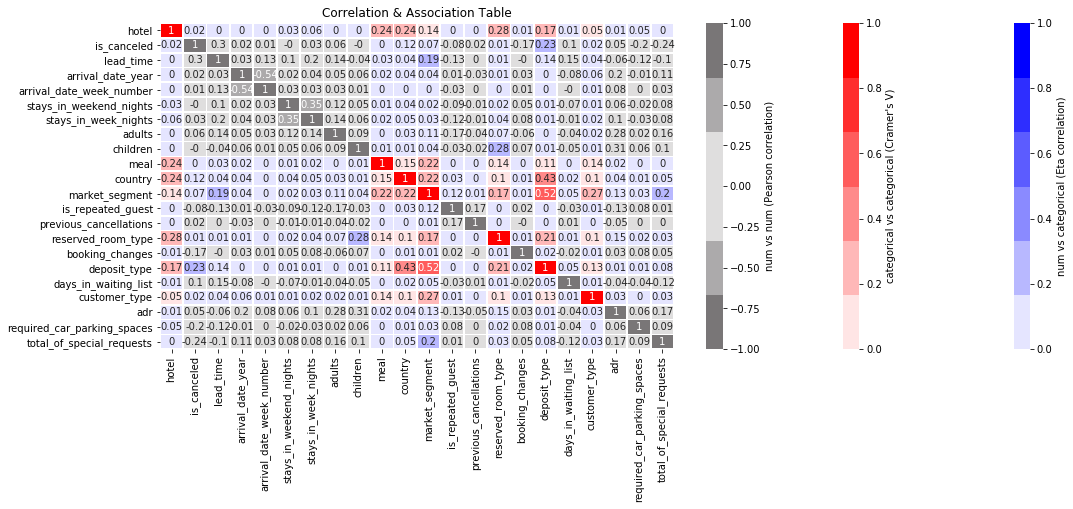

In [11]:
matrix_corr = np.around(matrix_corr, 2)

pd_matrix = pd.DataFrame(matrix_corr)
pd_matrix.columns = df.columns
pd_matrix.set_index(df.columns, inplace=True)

mask_num = np.where(matrix_mask == 1, False, True)
mask_cat = np.where(matrix_mask == 2, False, True)
mask_mixed = np.where(matrix_mask == 3, False, True)

cm_blue = sns.light_palette("blue", as_cmap=False)
cm_red = sns.light_palette("red", as_cmap=False)
cm_grey = sns.diverging_palette(h_neg=1, h_pos=1, s=1, as_cmap=False)

plt.figure(figsize = (18,6))
plt.title('Correlation & Association Table')

sns.heatmap(pd_matrix, annot=True, mask=mask_mixed, cmap=cm_blue, vmax=1, vmin=0, linewidths =.7, cbar_kws={'label': "num vs categorical (Eta correlation)"})
sns.heatmap(pd_matrix, annot=True, mask=mask_cat, cmap=cm_red, vmax=1, vmin=0, linewidths =.7, cbar_kws={'label': "categorical vs categorical (Cramer's V)"})
sns.heatmap(pd_matrix, annot=True, mask=mask_num, cmap=cm_grey, vmax=1, vmin=-1, linewidths =.7, cbar_kws={'label': "num vs num (Pearson correlation)"})

- We do not see any high or interesting values in the table (we were especially interested in absolute values greater or equal than 0.75). Therefore, we do not delete any column in this step

### - Handling Categorical features

- We are going to treat the 7 categorical features that we have: <span style='color:Orange'> **hotel** </span>, <span style='color:Orange'> **meal** </span>, <span style='color:Orange'> **country** </span>, <span style='color:Orange'> **market_segment** </span>, <span style='color:Orange'> **reserved_room_type** </span>, <span style='color:Orange'> **deposit_type** </span> and <span style='color:Orange'> **customer_type** </span> . For the moment we consider them as **ordinal categorical features**

- We are in a binary classification: we can encode the categorical features using Mean encoding with CV loops for regularization

In [12]:
cat_cols = df.columns[df.dtypes==object].tolist()

X = df.copy()
y = df['is_canceled'].values

# Splitting into train and test
# it returns dataframes with proper indices
# observe that X_train_orig will contain a copy of y
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=345)

In [13]:
pd.options.mode.chained_assignment = None # default='warn'

cat_cols = df.columns[df.dtypes == object].tolist() # colums that I want to change
global_train_mean = X_train_orig['is_canceled'].mean()

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

for tr_ind, val_ind in skf.split(X_train_orig, y_train_orig):
    print(tr_ind, val_ind)      #tr_ind and val_ind are positions/number of rows
    X_tr, X_val = X_train_orig.iloc[tr_ind], X_train_orig.iloc[val_ind]
   
    for col in cat_cols:
        means = X_val[col].map(X_tr.groupby(col)['is_canceled'].mean())
        X_train_orig.loc[X_train_orig.index[val_ind], col+'_new'] = means 

[    3     4     5 ... 95508 95509 95511] [    0     1     2 ... 95497 95502 95510]
[    0     1     2 ... 95508 95509 95510] [   21    28    43 ... 95504 95507 95511]
[    0     1     2 ... 95507 95510 95511] [    3     5    13 ... 95505 95508 95509]
[    0     1     2 ... 95509 95510 95511] [    4     6     9 ... 95500 95501 95506]
[    0     1     2 ... 95509 95510 95511] [    7     8    10 ... 95491 95493 95503]


In [14]:
for col in cat_cols:
    X_train_orig[col+'_new'].fillna(global_train_mean, inplace = True)
    X_test_orig[col] = X_test_orig[col].map(X_train_orig.groupby(col)[col+'_new'].mean())
    X_test_orig[col].fillna(global_train_mean, inplace=True)

In [15]:
X_train_orig.drop(cat_cols, axis = 1, inplace=True)

# Feature Importances and Selection

In [16]:
X_train_orig.var()

is_canceled                        0.233210
lead_time                      10088.569539
arrival_date_year                  0.501792
arrival_date_week_number          46.378141
stays_in_weekend_nights            0.820429
stays_in_week_nights               2.333256
adults                             0.225897
children                           0.067257
is_repeated_guest                  0.030973
previous_cancellations             0.003630
booking_changes                    0.248070
days_in_waiting_list               0.029952
adr                             2616.796773
required_car_parking_spaces        0.058315
total_of_special_requests          0.514533
hotel_new                          0.004352
meal_new                           0.000045
country_new                        0.028043
market_segment_new                 0.016667
reserved_room_type_new             0.001230
deposit_type_new                   0.054189
customer_type_new                  0.004300
dtype: float64

In [17]:
rfc_model = RandomForestClassifier()

z = X_train_orig.copy()
y = z['is_canceled']
X = z.drop('is_canceled', axis = 1)

# step tells you how many feature to remove at every step
# StratifiedKFold preserves the percentage of every class
# n_jobs is for parallel processing, -1 means all
rfecv = RFECV(estimator=rfc_model, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=123), 
              scoring='accuracy', n_jobs = -1, verbose = 1)

rfecv.fit(X, y)


RFECV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=1)

Optimal number of features : 21
Best features : Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_new', 'meal_new', 'country_new',
       'market_segment_new', 'reserved_room_type_new', 'deposit_type_new',
       'customer_type_new'],
      dtype='object')
Original features : Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_new', 'meal_new', 'country_new',
       'market_segment_new', 'reserved_room_type_new', 'deposit_type_new

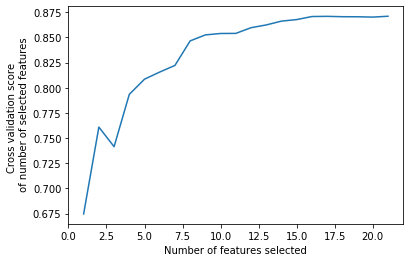

In [18]:
print("Optimal number of features : %d" % rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [19]:
print(rfecv.grid_scores_)
print(rfecv.ranking_)
print(rfecv.n_features_)
print(X.columns[rfecv.support_])
rfecv.estimator_.feature_importances_

[0.67461682 0.76089915 0.74144611 0.79342912 0.80853716 0.81560437
 0.82222134 0.84658475 0.85253159 0.85393456 0.85402881 0.85969302
 0.86243613 0.86621577 0.86775484 0.87079112 0.87096909 0.87061312
 0.87055029 0.87022573 0.8710738 ]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
21
Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_new', 'meal_new', 'country_new',
       'market_segment_new', 'reserved_room_type_new', 'deposit_type_new',
       'customer_type_new'],
      dtype='object')


array([0.15133849, 0.02727411, 0.07032069, 0.02742545, 0.041786  ,
       0.01549024, 0.00594533, 0.00336519, 0.00089755, 0.02171832,
       0.00249927, 0.10073164, 0.02426597, 0.05127345, 0.02310603,
       0.0242716 , 0.11208258, 0.07683881, 0.02833111, 0.14620594,
       0.04483225])

In [20]:
num_feature = rfecv.n_features_
tab_general = pd.DataFrame ({ 'rank': rfecv.ranking_ , 'variables': X.columns.tolist()})
tab_rank = tab_general.copy()
tab_importances = tab_general.copy()

tab_rank = pd.DataFrame(tab_general.groupby('rank')['variables'].apply(list))
tab_rank['score']= rfecv.grid_scores_[num_feature-1 : len(rfecv.grid_scores_)]


tab_importances = tab_importances[tab_importances['rank']==1].drop('rank', axis = 1)
tab_importances['importances'] = rfecv.estimator_.feature_importances_
tab_importances.sort_values(by = 'importances', ascending = False, inplace = True)
tab_importances.reset_index(drop=True, inplace=True)


- It is evident from our tab_importances that deposit_type is the most relevant feature. It has the greatest importance score by far (0.50), while the second highest score is 0.069
- At the same time the scores of the model does not change a lot while we eliminate the least relevant features. However, to avoid taking too much complexity in the model we decide to keep only the features suggested by RFECV

In [21]:
tab_rank[tab_rank.index == 1]['variables']
important_features_train = [x for x in tab_rank[tab_rank.index == 1]['variables']][0]
X_train_orig = X_train_orig[[x for x in important_features_train]]

important_features_test = [x.replace("_new", "") for x in important_features_train]
X_test_orig = X_test_orig[[x for x in important_features_test]]

### - Feature scaling

In [22]:
# min-max transformation
# to mantain same distribution

min_max = MinMaxScaler()
X_train_scaled = X_train_orig.copy()
X_test_scaled = X_test_orig.copy()

X_train_scaled[X_train_scaled.columns] = min_max.fit_transform(X_train_orig[X_train_orig.columns])
X_test_scaled[X_test_scaled.columns] = min_max.transform(X_test_orig[X_test_orig.columns])


# MODELLING

- We create two models using XGBoost and Logistic regression. At the very beginning we use the default hyperparameters just to get a general idea. After that, we will perform a hyperparameters tuning

In [23]:
# We set the two algorithms
xgb_clf = xgb.XGBClassifier()
logit = LogisticRegression(solver='liblinear')

In [24]:
# We get rid of then "_new" string in the scaled DataFrame
X_train_scaled.columns = X_train_scaled.columns.str.replace("_new", "")

## - XGBoost

In [25]:
xgb_model_default = classifier_gridCV(X_train_scaled, y_train_orig, xgb.XGBClassifier(),
                                     X_test_scaled, y_test_orig, model_name = "xg_boost")


The best parameters of grid are:  {} 
The best estimator is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
The results on the test are: 
Precision = 0.85346723083261
Recall = 0.8435964225227959
Accuracy = 0.8600804087444509


Text(0.5, 1, 'Confusion Matrix')

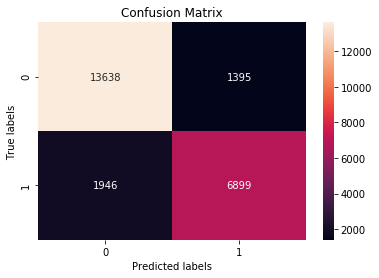

In [31]:
# Looking at the confusion matrix on the test
pred_xgb = xgb_model_default.predict(X_test_scaled)
cm_xgb=metrics.confusion_matrix(y_test_orig, pred_xgb)
classes_xgb = xgb_model_default.classes_

ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [32]:
# Looking at the cohen score on the test
cohen_score_xgb = cohen_kappa_score(y_test_orig, pred_xgb)
cohen_score_xgb

0.6961179065782215

- The Cohen score is quite good: is clearly above 0.5 but it does not reach 0.8

## - Logistic Regression

In [33]:
logistic_model_default = classifier_gridCV(X_train_scaled, y_train_orig, logit,
                                         X_test_scaled, y_test_orig, model_name = "logistic_regression")


The best parameters of grid are:  {} 
The best estimator is:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
The results on the test are: 
Precision = 0.7905806169242637
Recall = 0.745801584356887
Accuracy = 0.7888014071530279


Text(0.5, 1, 'Confusion Matrix')

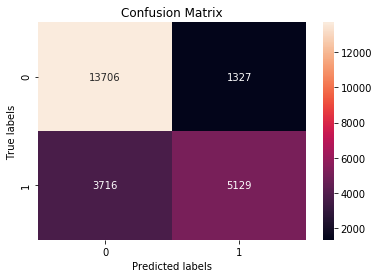

In [34]:
# Looking at the confusion matrix on the test
pred_logistic = logistic_model_default.predict(X_test_scaled)
cm_logistic=metrics.confusion_matrix(y_test_orig, pred_logistic)
classes_logistic = logistic_model_default.classes_

ax = plt.subplot()
sns.heatmap(cm_logistic, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [35]:
# Looking at the cohen score on the test
cohen_score_logistic = cohen_kappa_score(y_test_orig, pred_logistic)
cohen_score_logistic

0.5205397248483199

- The Cohen score is not satisfactory for us: it is about 0.5

## XGBoost vs Logistic Regression: ROC Curve

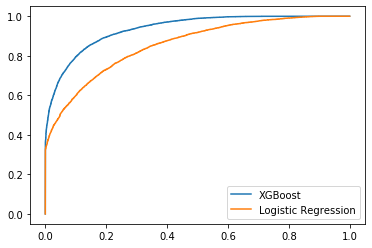

The AUC for xgboost is: 0.9359959436516844
The AUC for the logistic regression is: 0.8566790821639538


In [45]:
probabilities_xgb = xgb_model_default.predict_proba(X_test_scaled)[:,1]
probabilities_logistic = logistic_model_default.predict_proba(X_test_scaled)[:,1]

fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test_orig, probabilities_xgb, pos_label=1)
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test_orig, probabilities_logistic, pos_label=1)


# Print ROC curve
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_logistic, tpr_logistic, label="Logistic Regression")
plt.legend()
plt.show()

# Print AUC
auc_xgb = np.trapz(tpr_xgb, fpr_xgb)
print('The AUC for xgboost is:', auc_xgb)

auc_logistic = np.trapz(tpr_logistic, fpr_logistic)
print('The AUC for the logistic regression is:', auc_logistic)


 - Both the AUC scores are very good, especially the one for xgboost
 - Considering all the metrics, we consider the xgboost model much more robust and reliable. For these reasons and given our computational resources, we decid to perform the hyperparameter tuning only on the XGBoost algorithm 

# XGBoost: Hyperparameters Tuning

## Coarse to fine approach

The approach that we are going to use is the following:
- We supply a distribution space (uniform) for each hyperparameter that we want to tune
- We use an optimizer (TPE) to minimize the loss (i.e. 1-accuracy)
- Analyzing the results, we will find the best perforiming regions for the hyperparameters
- Finally, we perform a GridSearchCV on the most interesting regions

Note: for computational reasons, we take at most 75 estimators

In [48]:
space = {
    'max_depth': hp.uniform ('max_depth', 5, 20),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'n_estimators': hp.uniform('n_estimators', 30, 75)
}

def objective(params):
    params = {
        'max_depth': [int(params['max_depth'])],
        'learning_rate': [params['learning_rate']],
        'n_estimators': [int(params['n_estimators'])]
    }
    grid = GridSearchCV(xgb.XGBClassifier(), params, scoring='accuracy', 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, 
                                            random_state=42), 
                        n_jobs=-1)
    model = grid.fit(X_train_scaled, y_train_orig)
    mean_score = model.cv_results_["mean_test_score"][0]
    loss = 1- mean_score
    return loss

trials = Trials()

best_result = fmin(
             fn = objective,
             space = space,
             trials = trials,
             max_evals = 50,
             rstate = np.random.RandomState(42),
             algo = tpe.suggest)



0.8673988553080368                                    
0.8587821346822867                                                               
0.8675873101240628                                                               
0.8688751262635099                                                               
0.8590752730379464                                                               
0.8625617882564918                                                               
0.8692415537298033                                                               
0.8668439900164181                                                               
0.8648965510539597                                                               
0.8591381106756992                                                               
0.8596721015220854                                                                
0.8637553191647374                                                                
0.8517254146337819                       

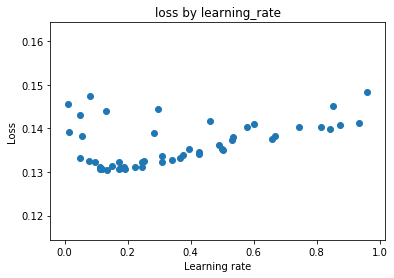

In [50]:
learning_rates = [t['misc']['vals']['learning_rate'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials]
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('loss by learning_rate')

plt.scatter(learning_rates, loss)

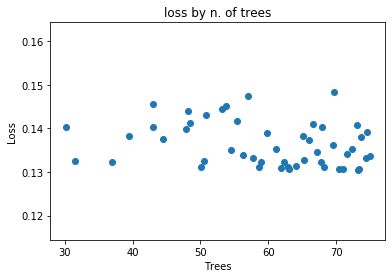

In [52]:
trees = [t['misc']['vals']['n_estimators'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials]
plt.xlabel('Trees')
plt.ylabel('Loss')
plt.title('loss by n. of trees')

plt.scatter(trees, loss)

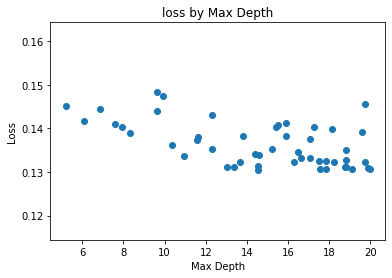

In [53]:
depth = [t['misc']['vals']['max_depth'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials]
plt.xlabel('Max Depth')
plt.ylabel('Loss')
plt.title('loss by Max Depth')

plt.scatter(depth, loss)

In [54]:
best_parameters_hp = pd.DataFrame({'max_depth':depth, 'n_estimators':trees, 
                                   'learning_rate':learning_rates, 'loss':loss}).sort_values(by='loss', ascending= True)

In [75]:
print(best_parameters_hp.iloc[0])

max_depth         [14.538637413702196]
n_estimators       [73.25242731623263]
learning_rate    [0.13527611625682356]
loss                          0.130518
Name: 44, dtype: object


Having just 50 points, the patterns are not so clear. However, looking at the charts, it is not so difficult to deduce the following properties:
- the learning rate should be in the interval [0.1, 0.2]
- the max_depth should be greater or equal than 13
- the n_estimators should be greater than 70, since the variance since smaller there

### GridSearcCV with the most promising parameters

In [76]:
parameters = {
    'learning_rate':[0.1, 0.13, 0.15, 0.17, 0.2],
    'n_estimators':[70, 75, 80, 85, 90],
    'max_depth':[13, 14, 15, 16, 17]
    
}

In [77]:
xgb_model_tuned = classifier_gridCV(X_train_scaled, y_train_orig, xgb.XGBClassifier(),
                                     X_test_scaled, y_test_orig, params=parameters,
                                    model_name = "xg_boost_tuned")

The best parameters of grid are:  {'learning_rate': 0.13, 'max_depth': 17, 'n_estimators': 90} 
The best estimator is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.13, max_delta_step=0, max_depth=17,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
The results on the test are: 
Precision = 0.8703222084278258
Recall = 0.8615871425430475
Accuracy = 0.8759946394170366


- We improved the accuracy by 0.7%. It seems our strategy took us on the right path. We check the Cohen score and the ROC curve too

Text(0.5, 1, 'Confusion Matrix')

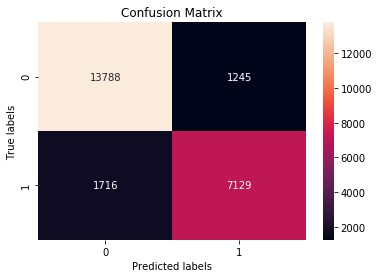

In [78]:
# Looking at the confusion matrix on the test
pred_xgb_tuned = xgb_model_tuned.predict(X_test_scaled)
cm_xgb_tuned=metrics.confusion_matrix(y_test_orig, pred_xgb_tuned)
classes_logistic = xgb_model_tuned.classes_

ax = plt.subplot()
sns.heatmap(cm_xgb_tuned, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [79]:
# Looking at the cohen score on the test
cohen_score_xgb_tuned = cohen_kappa_score(y_test_orig, pred_xgb_tuned)
cohen_score_xgb_tuned

0.7311878673262899

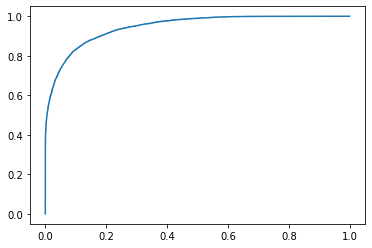

The AUC is: 0.9458514087924974


In [81]:
probabilities_xgb_tuned = xgb_model_tuned.predict_proba(X_test_scaled)[:,1]
fpr_xgb_tuned, tpr_xgb_tuned, thresholds_xgb_tuned = metrics.roc_curve(y_test_orig, probabilities_xgb_tuned,
                                                                       pos_label=1)


# Print ROC curve
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned)
plt.show()

# Print AUC
auc_xgb_tuned = np.trapz(tpr_xgb_tuned, fpr_xgb_tuned)
print('The AUC is:', auc_xgb_tuned)


- Both the metrics improved, so in general we can claim that our hyperparameter strategy worked 

In [84]:
import pickle

filename = "xgboost_tuned.sav"
pickle.dump(xgb_model_tuned, open(filename, 'wb'))

In [85]:
# some time later...

#load the model from disk
xgb_model_tuned_2 = pickle.load(open(filename, 'rb'))

In [86]:
xgb_model_tuned_2

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_w...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
       

In [89]:
xgb_model_tuned_2.best_params_

{'learning_rate': 0.13, 'max_depth': 17, 'n_estimators': 90}

# THE END